## ***Project Name: Ariel Object Detection (Bird vs Drone)***

#### Project done by : Manav Bhavsar

***Github Profile:*** https://github.com/mechahuman  
***Github Repo:*** 

## Problem Statement

This project aims to develop a deep learning-based solution that can classify aerial images into two categories — Bird or Drone — and optionally perform object detection to locate and label these objects in real-world scenes.


The solution will help in security surveillance, wildlife protection, and airspace safety where accurate identification between drones and birds is critical. The project involves building a Custom CNN classification model, leveraging transfer learning, and optionally implementing YOLOv8 for real-time object detection. The final solution will be deployed using Streamlit for interactive use.


### ***Importing all the necessary libraries***

In [127]:
from pathlib import Path
import os
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt

from ultralytics import YOLO

In [125]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model


from tensorflow.keras.applications import EfficientNetB0

In [126]:
import mlflow
import mlflow.keras

### ***Understanding the dataset***
We get to know our classification dataset by:
+ Check if the folder paths are valid and existing.
  
+ We count the number of images of each class (bird , drone) in train, test, valid folders.

+ We check if there is any imbalance in the dataset provided and if each class is well numbered and if they are almost equal.

+ We look at random samples from each folder to get further idea about the dataset.

In [90]:
# We point at the dataset

base_path = Path("classification_dataset/")
base_path, base_path.exists()

(WindowsPath('classification_dataset'), True)

In [91]:
splits = ['train', 'test', 'valid']

for split in splits:
    split_path = base_path / split
    print(split,": ",split_path, " exists: ",split_path.exists())

train :  classification_dataset\train  exists:  True
test :  classification_dataset\test  exists:  True
valid :  classification_dataset\valid  exists:  True


In [92]:
classes = ['bird', 'drone']

for split in splits:
    print(f"Checking: {split}")
    for cls in classes:
        class_folder = base_path / split/ cls
        print(f"{cls} : {class_folder} exists: {class_folder.exists()}")

    print("\n")

Checking: train
bird : classification_dataset\train\bird exists: True
drone : classification_dataset\train\drone exists: True


Checking: test
bird : classification_dataset\test\bird exists: True
drone : classification_dataset\test\drone exists: True


Checking: valid
bird : classification_dataset\valid\bird exists: True
drone : classification_dataset\valid\drone exists: True




In [93]:
# We count the number of images in each class_folder

counts = []

for split in splits:
    for cls in classes:
        class_folder = base_path / split / cls
        num_images = len(list(class_folder.glob("*.jpg")))
        counts.append((split, cls, num_images))
        print(f"{split:5}, {cls:5}, images: {num_images}")

train, bird , images: 1414
train, drone, images: 1248
test , bird , images: 121
test , drone, images: 94
valid, bird , images: 217
valid, drone, images: 225


In [94]:
counts

[('train', 'bird', 1414),
 ('train', 'drone', 1248),
 ('test', 'bird', 121),
 ('test', 'drone', 94),
 ('valid', 'bird', 217),
 ('valid', 'drone', 225)]

In [95]:
# We compare brid vs drone split in each case

df_counts = pd.DataFrame(counts, columns = ['Split','Class','Count'])

df_counts

,Split,Class,Count
0,train,bird,1414
1,train,drone,1248
2,test,bird,121
3,test,drone,94
4,valid,bird,217
5,valid,drone,225


In [96]:
df_counts_pivot = df_counts.pivot(index="Split",columns='Class',values='Count')

df_counts_pivot

Class,bird,drone
Split,,
test,121,94
train,1414,1248
valid,217,225


The numbers are fairly close so there is almost minimal imbalance in the dataset provided. This is good for the classification model implementation on the later stage.

In [97]:
# We visualize random 5 samples from the from train, test, valid folders for both classes

def show_samples(split ,cls ,n=5):
    folder_path = base_path / split / cls

    image_paths = list(folder_path.glob("*.jpg"))

    sample_paths = random.sample(image_paths, n)

    plt.figure(figsize=(3*n,3))

    for i, img_path in enumerate(sample_paths):
        img_bgr = cv2.imread(str(img_path))
        if img_bgr is None:
            print("Could not read the image.")
            continue

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # matplotlib supports RGB

        plt.subplot(1, n, i + 1)
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.title(cls)

    plt.show()

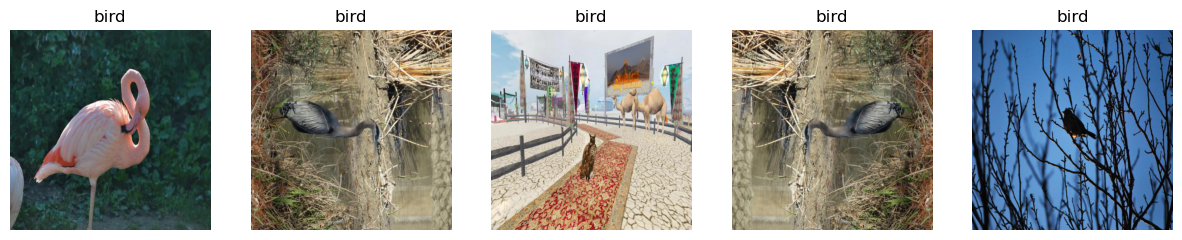

In [98]:
# train samples - bird
show_samples(split='train',cls = 'bird')

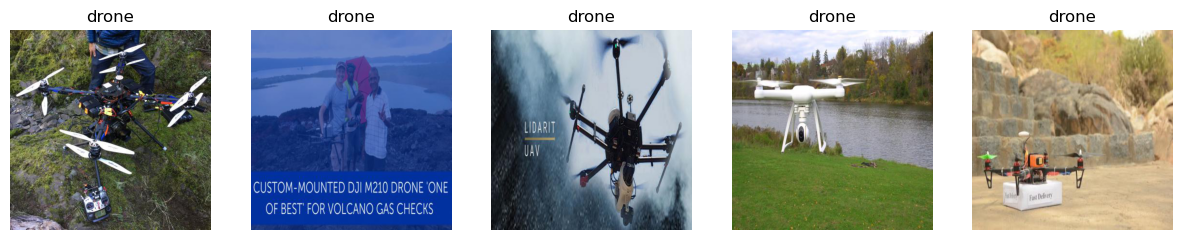

In [99]:
# train samples - drone
show_samples(split='test',cls = 'drone')

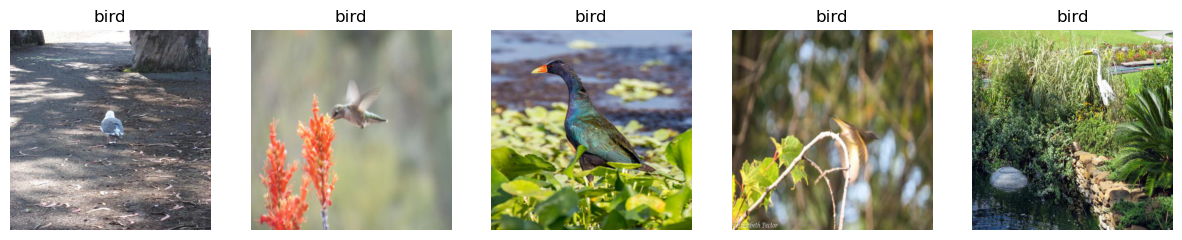

In [100]:
# test samples - bird
show_samples(split='test',cls = 'bird')

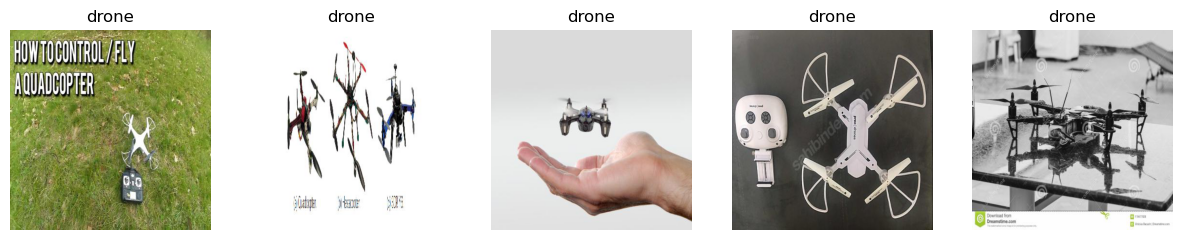

In [101]:
# test samples - drone
show_samples(split='test',cls = 'drone')

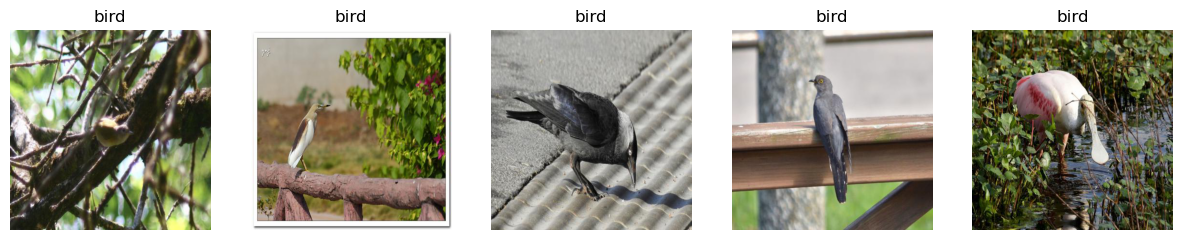

In [102]:
# valid samples - bird
show_samples(split='valid',cls = 'bird')

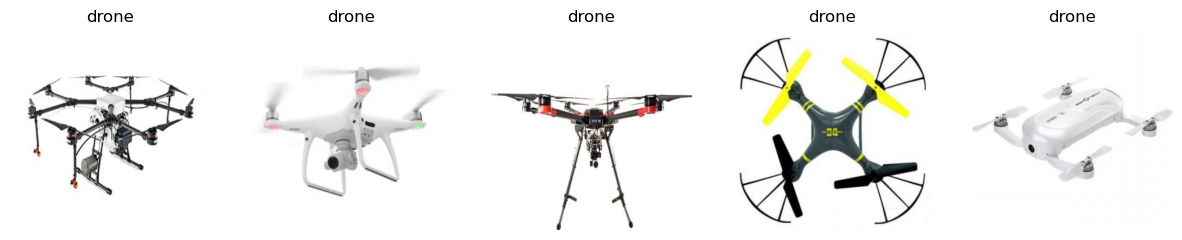

In [103]:
# valid samples - drone
show_samples(split='valid',cls = 'drone')

### ***Data Preprocessing***

+ We normalize the pixel values to [0, 1].

+ Resize the images to a fixed size of (244 x 244) for classification.

In [104]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0
)

val_datagen = ImageDataGenerator(
    rescale = 1.0/255.0
)

test_datagen = ImageDataGenerator(
    rescale = 1.0/255.0
)


train_gen = train_datagen.flow_from_directory(
    base_path / "train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=(BATCH_SIZE),
    class_mode="binary"
)

test_gen = test_datagen.flow_from_directory(
    base_path / "test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=(BATCH_SIZE),
    class_mode="binary",
    shuffle=False
)

valid_gen = val_datagen.flow_from_directory(
    base_path / "valid",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=(BATCH_SIZE),
    class_mode="binary"
)

Found 2662 images belonging to 2 classes.
Found 215 images belonging to 2 classes.
Found 442 images belonging to 2 classes.


### ***Data Augmentation***

Here we rescale (normalize) the picture along with:
+ Applying transformations like rotation, flipping, zoom, brightness control, cropping etc.

In [105]:
train_aug_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    rotation_range = 20,           # rotates image by +-20 degrees
    width_shift_range=0.1,         # shift left/right 10%
    height_shift_range=0.1,        # shift up_down 10%
    zoom_range=0.2,                # random zooming (in/out) 20%
    brightness_range=[0.8,1.2],    # brightness variation
    horizontal_flip=True           # flip horizontally
)


train_aug_gen = train_aug_datagen.flow_from_directory(
    base_path / "train",
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode= "binary",
    shuffle = True
    
)

Found 2662 images belonging to 2 classes.


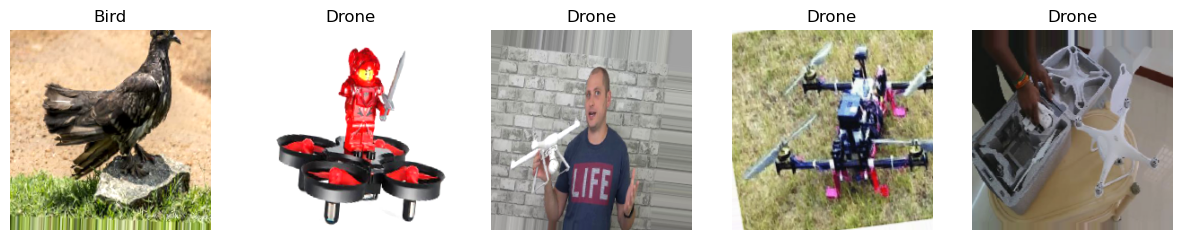

In [121]:
x_batch, y_batch = next(train_aug_gen)

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_batch[i])
    plt.axis("off")
    label = "Drone" if y_batch[i] == 1 else "Bird"
    plt.title(label)
plt.show()

### ***Model - Custom Convolutional Neural Network (CNN)***

+ We use 4 Blocks for getting accurate results.
  
+ MaxPooling, BatchNormalization, Dense output layers are used.

In [107]:
def build_custom_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(shape=input_shape)

    # Block 1 selection
    x = layers.Conv2D(32, (3,3), activation = "relu", padding = "same")(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.BatchNormalization()(x)

    # Block 2 selection
    x = layers.Conv2D(64, (3,3), activation = "relu", padding = "same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.BatchNormalization()(x)

    # Block 3 selection
    x = layers.Conv2D(128, (3,3), activation = "relu", padding= "same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.BatchNormalization()(x)

    # Block 4 selection
    x = layers.Conv2D(256, (3,3), activation = "relu", padding= "same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.BatchNormalization()(x)

    # Global pooling + dense layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation= "relu")(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(1, activation = "sigmoid")(x)

    model = models.Model(inputs, outputs, name = "bird_vs_drone_cnn")
    return model

cnn_model = build_custom_cnn()
cnn_model.summary()

Model: "bird_vs_drone_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 423,361 (1.61 MB)

 Trainable params: 422,401 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [108]:
cnn_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = "binary_crossentropy",
    metrics = ["accuracy", "precision", "recall"]
)

In [109]:
checkpoint_path = "best_cnn_model.h5"

early_stop = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath = checkpoint_path,
    monitor = "val_loss",
    save_best_only = True,
    verbose = 1
)

In [110]:
EPOCHS = 30

history = cnn_model.fit(
    train_aug_gen,
    validation_data=valid_gen,
    epochs = EPOCHS,
    callbacks = [early_stop, checkpoint]
)

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.6483 - loss: 0.6621 - precision: 0.6413 - recall: 0.6020
Epoch 1: val_loss improved from None to 0.68930, saving model to best_cnn_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 80s 904ms/step - accuracy: 0.6788 - loss: 0.6219 - precision: 0.6719 - recall: 0.6154 - val_accuracy: 0.4910 - val_loss: 0.6893 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.7211 - loss: 0.5602 - precision: 0.7296 - recall: 0.6330
Epoch 2: val_loss did not improve from 0.68930
84/84 ━━━━━━━━━━━━━━━━━━━━ 73s 865ms/step - accuracy: 0.7269 - loss: 0.5524 - precision: 0.7341 - recall: 0.6546 - val_accuracy: 0.4910 - val_loss: 0.7447 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.7478 - loss: 0.5168 - precision: 0.7384 - recall: 0.6999
Epoch 3: val_loss improved from 0.68930 to 0.66403, saving model to best_cnn_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 74s 878ms/step - accuracy: 0.7472 - loss: 0.5164 - precision: 0.7538 - recall: 0.6843 - val_accuracy: 0.6267 - val_loss: 0.6640 - val_precision: 0.7727 - val_recall: 0.3778
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 839ms/step - accuracy: 0.7428 - loss: 0.4987 - precision: 0.7458 - recall: 0.7063
Epoch 4: val_loss improved from 0.66403 to 0.62255, saving model to best_cnn_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 73s 868ms/step - accuracy: 0.7491 - loss: 0.4980 - precision: 0.7462 - recall: 0.7043 - val_accuracy: 0.6742 - val_loss: 0.6225 - val_precision: 0.9551 - val_recall: 0.3778
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.7498 - loss: 0.5016 - precision: 0.7541 - recall: 0.7051
Epoch 5: val_loss improved from 0.62255 to 0.61704, saving model to best_cnn_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 74s 879ms/step - accuracy: 0.7615 - loss: 0.4902 - precision: 0.7613 - recall: 0.7155 - val_accuracy: 0.6606 - val_loss: 0.6170 - val_precision: 0.9630 - val_recall: 0.3467
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.7677 - loss: 0.4778 - precision: 0.7996 - recall: 0.6974
Epoch 6: val_loss improved from 0.61704 to 0.49139, saving model to best_cnn_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 74s 880ms/step - accuracy: 0.7618 - loss: 0.4878 - precision: 0.7688 - recall: 0.7035 - val_accuracy: 0.7398 - val_loss: 0.4914 - val_precision: 0.7835 - val_recall: 0.6756
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.7643 - loss: 0.4868 - precision: 0.7771 - recall: 0.7030
Epoch 7: val_loss improved from 0.49139 to 0.46116, saving model to best_cnn_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 74s 872ms/step - accuracy: 0.7739 - loss: 0.4722 - precision: 0.7765 - recall: 0.7268 - val_accuracy: 0.7557 - val_loss: 0.4612 - val_precision: 0.8232 - val_recall: 0.6622
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - accuracy: 0.7926 - loss: 0.4350 - precision: 0.7933 - recall: 0.7407
Epoch 8: val_loss improved from 0.46116 to 0.42543, saving model to best_cnn_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 74s 879ms/step - accuracy: 0.7829 - loss: 0.4470 - precision: 0.7970 - recall: 0.7204 - val_accuracy: 0.8054 - val_loss: 0.4254 - val_precision: 0.8263 - val_recall: 0.7822
Epoch 9/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.7928 - loss: 0.4406 - precision: 0.7825 - recall: 0.7587
Epoch 9: val_loss did not improve from 0.42543
84/84 ━━━━━━━━━━━━━━━━━━━━ 77s 915ms/step - accuracy: 0.7870 - loss: 0.4503 - precision: 0.7830 - recall: 0.7548 - val_accuracy: 0.7647 - val_loss: 0.4406 - val_precision: 0.7895 - val_recall: 0.7333
Epoch 10/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.7981 - loss: 0.4376 - precision: 0.8133 - recall: 0.7328
Epoch 10: val_loss did not improve from 0.42543
84/84 ━━━━━━━━━━━━━━━━━━━━ 78s 931ms/step - accuracy: 0.7930 - loss: 0.4408 - precision: 0.8038 - recall: 0.7388 - val_accuracy: 0.7805 - val_loss: 0.4502 - val_precision: 0.8299 - val_recall: 0.7156
Epoch 11/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - acc

2025/11/24 15:42:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='epochs' was already logged with value='100' for run ID='a8dc567f937f416a997b6c8494465c28'. Attempted logging new value '30'.


In [111]:
print("Training accuracy from CNN: ",history.history['accuracy'][-1])
print("Training loss from CNN: ",history.history['loss'][-1])
print("Training precision from CNN: ",history.history['precision'][-1])
print("Training recall from CNN: ",history.history['recall'][-1])
print("Validation accuracy from CNN: ",history.history['val_accuracy'][-1])

Training accuracy from CNN:  0.7945154309272766
Training loss from CNN:  0.44737085700035095
Training precision from CNN:  0.8071866631507874
Training recall from CNN:  0.7379807829856873
Validation accuracy from CNN:  0.8009049892425537


Using the custom CNN deep learning model:

+ We only get an accuracy of 79.4%.

+ We get a validation accuracy of only 80%.

+ We get a loss of 44.7%.

This indicates that it is not effective to use this model for classification and deployment. We will move forward with Transfer Learning for better results.

### ***Model - Transfer Learning using EfficientNetB0***

+ We use the custom EfficientnetB0 preprocessing input and preprocessing the training, testing and valid data.

+ We also use EarlyStopping and Checkpoints to save the best weights.

In [143]:
from tensorflow.keras.applications.efficientnet import preprocess_input

train_tl_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_tl_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_tl_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

simple_gen = train_tl_datagen.flow_from_directory(
    base_path / "train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

valid_tl_gen = val_tl_datagen.flow_from_directory(
    base_path / "valid",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_tl_gen = test_tl_datagen.flow_from_directory(
    base_path / "test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle = False
)

Found 2662 images belonging to 2 classes.
Found 442 images belonging to 2 classes.
Found 215 images belonging to 2 classes.


In [134]:
def build_efficientnet_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    base_model = EfficientNetB0(
        include_top= False,
        weights = "imagenet",
        input_shape = input_shape
    )

    base_model.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training = False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation = "sigmoid")(x)

    model = models.Model(inputs, outputs, name="bird_vs_drone_transferlearning")
    return model

tl_model = build_efficientnet_model()
tl_model.summary()

Model: "bird_vs_drone_transferlearning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [135]:
tl_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss = "binary_crossentropy",
    metrics = ["accuracy", "precision", "recall"]
)

In [136]:
tl_checkpoint_path = "best_tl_model.h5"

early_stop_tl = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

checkpoint_tl = ModelCheckpoint(
    filepath=tl_checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [137]:
history_tl = tl_model.fit(
    simple_gen,
    validation_data= valid_tl_gen,
    epochs = 30,
    callbacks = [early_stop_tl, checkpoint_tl]
)

2025/11/25 13:22:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7f16a2e0055a4ed794e5da2fdd6ae8f9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/11/25 13:22:06 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/11/25 13:22:06 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.


Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.5576 - loss: 0.6891 - precision: 0.5348 - recall: 0.7460
Epoch 1: val_loss improved from None to 0.37255, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 85s 885ms/step - accuracy: 0.6818 - loss: 0.5898 - precision: 0.6210 - recall: 0.8245 - val_accuracy: 0.9480 - val_loss: 0.3725 - val_precision: 0.9208 - val_recall: 0.9822
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9029 - loss: 0.3647 - precision: 0.8813 - recall: 0.9230
Epoch 2: val_loss improved from 0.37255 to 0.23612, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 454ms/step - accuracy: 0.9128 - loss: 0.3335 - precision: 0.8956 - recall: 0.9215 - val_accuracy: 0.9661 - val_loss: 0.2361 - val_precision: 0.9646 - val_recall: 0.9689
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9507 - loss: 0.2416 - precision: 0.9547 - recall: 0.9414
Epoch 3: val_loss improved from 0.23612 to 0.17814, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 37s 438ms/step - accuracy: 0.9549 - loss: 0.2343 - precision: 0.9541 - recall: 0.9495 - val_accuracy: 0.9683 - val_loss: 0.1781 - val_precision: 0.9689 - val_recall: 0.9689
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9569 - loss: 0.1979 - precision: 0.9633 - recall: 0.9447
Epoch 4: val_loss improved from 0.17814 to 0.14658, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 37s 449ms/step - accuracy: 0.9628 - loss: 0.1838 - precision: 0.9667 - recall: 0.9535 - val_accuracy: 0.9683 - val_loss: 0.1466 - val_precision: 0.9689 - val_recall: 0.9689
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9651 - loss: 0.1613 - precision: 0.9722 - recall: 0.9537
Epoch 5: val_loss improved from 0.14658 to 0.12669, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 37s 438ms/step - accuracy: 0.9628 - loss: 0.1597 - precision: 0.9622 - recall: 0.9583 - val_accuracy: 0.9774 - val_loss: 0.1267 - val_precision: 0.9778 - val_recall: 0.9778
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9653 - loss: 0.1462 - precision: 0.9674 - recall: 0.9584
Epoch 6: val_loss improved from 0.12669 to 0.11305, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 37s 445ms/step - accuracy: 0.9677 - loss: 0.1401 - precision: 0.9701 - recall: 0.9607 - val_accuracy: 0.9819 - val_loss: 0.1130 - val_precision: 0.9822 - val_recall: 0.9822
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9674 - loss: 0.1233 - precision: 0.9697 - recall: 0.9596
Epoch 7: val_loss improved from 0.11305 to 0.10359, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 37s 439ms/step - accuracy: 0.9688 - loss: 0.1211 - precision: 0.9740 - recall: 0.9591 - val_accuracy: 0.9819 - val_loss: 0.1036 - val_precision: 0.9822 - val_recall: 0.9822
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9702 - loss: 0.1174 - precision: 0.9819 - recall: 0.9529
Epoch 8: val_loss improved from 0.10359 to 0.09606, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 37s 445ms/step - accuracy: 0.9726 - loss: 0.1138 - precision: 0.9796 - recall: 0.9615 - val_accuracy: 0.9819 - val_loss: 0.0961 - val_precision: 0.9822 - val_recall: 0.9822
Epoch 9/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9777 - loss: 0.1039 - precision: 0.9794 - recall: 0.9721
Epoch 9: val_loss improved from 0.09606 to 0.09026, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 37s 436ms/step - accuracy: 0.9733 - loss: 0.1050 - precision: 0.9742 - recall: 0.9688 - val_accuracy: 0.9819 - val_loss: 0.0903 - val_precision: 0.9822 - val_recall: 0.9822
Epoch 10/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9797 - loss: 0.0919 - precision: 0.9841 - recall: 0.9732
Epoch 10: val_loss improved from 0.09026 to 0.08529, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 36s 430ms/step - accuracy: 0.9767 - loss: 0.0940 - precision: 0.9782 - recall: 0.9720 - val_accuracy: 0.9819 - val_loss: 0.0853 - val_precision: 0.9822 - val_recall: 0.9822
Epoch 11/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9775 - loss: 0.0894 - precision: 0.9796 - recall: 0.9720
Epoch 11: val_loss improved from 0.08529 to 0.08151, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 37s 439ms/step - accuracy: 0.9782 - loss: 0.0888 - precision: 0.9822 - recall: 0.9712 - val_accuracy: 0.9819 - val_loss: 0.0815 - val_precision: 0.9822 - val_recall: 0.9822
Epoch 12/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.9798 - loss: 0.0829 - precision: 0.9803 - recall: 0.9776
Epoch 12: val_loss improved from 0.08151 to 0.07823, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 471ms/step - accuracy: 0.9805 - loss: 0.0823 - precision: 0.9776 - recall: 0.9808 - val_accuracy: 0.9819 - val_loss: 0.0782 - val_precision: 0.9822 - val_recall: 0.9822
Epoch 13/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9800 - loss: 0.0777 - precision: 0.9810 - recall: 0.9775
Epoch 13: val_loss improved from 0.07823 to 0.07545, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 456ms/step - accuracy: 0.9801 - loss: 0.0803 - precision: 0.9815 - recall: 0.9760 - val_accuracy: 0.9819 - val_loss: 0.0754 - val_precision: 0.9822 - val_recall: 0.9822
Epoch 14/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9785 - loss: 0.0765 - precision: 0.9752 - recall: 0.9791
Epoch 14: val_loss improved from 0.07545 to 0.07317, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 39s 461ms/step - accuracy: 0.9808 - loss: 0.0746 - precision: 0.9792 - recall: 0.9800 - val_accuracy: 0.9819 - val_loss: 0.0732 - val_precision: 0.9822 - val_recall: 0.9822
Epoch 15/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9807 - loss: 0.0752 - precision: 0.9862 - recall: 0.9719
Epoch 15: val_loss improved from 0.07317 to 0.07137, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - accuracy: 0.9820 - loss: 0.0730 - precision: 0.9847 - recall: 0.9768 - val_accuracy: 0.9819 - val_loss: 0.0714 - val_precision: 0.9822 - val_recall: 0.9822
Epoch 16/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9829 - loss: 0.0666 - precision: 0.9831 - recall: 0.9809
Epoch 16: val_loss improved from 0.07137 to 0.06949, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 39s 462ms/step - accuracy: 0.9801 - loss: 0.0713 - precision: 0.9799 - recall: 0.9776 - val_accuracy: 0.9819 - val_loss: 0.0695 - val_precision: 0.9822 - val_recall: 0.9822
Epoch 17/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9829 - loss: 0.0649 - precision: 0.9839 - recall: 0.9797
Epoch 17: val_loss improved from 0.06949 to 0.06779, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 39s 463ms/step - accuracy: 0.9808 - loss: 0.0663 - precision: 0.9800 - recall: 0.9792 - val_accuracy: 0.9819 - val_loss: 0.0678 - val_precision: 0.9822 - val_recall: 0.9822
Epoch 18/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9868 - loss: 0.0626 - precision: 0.9854 - recall: 0.9865
Epoch 18: val_loss improved from 0.06779 to 0.06640, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 453ms/step - accuracy: 0.9838 - loss: 0.0640 - precision: 0.9816 - recall: 0.9840 - val_accuracy: 0.9819 - val_loss: 0.0664 - val_precision: 0.9822 - val_recall: 0.9822
Epoch 19/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9848 - loss: 0.0594 - precision: 0.9793 - recall: 0.9885
Epoch 19: val_loss improved from 0.06640 to 0.06513, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 450ms/step - accuracy: 0.9865 - loss: 0.0600 - precision: 0.9840 - recall: 0.9872 - val_accuracy: 0.9842 - val_loss: 0.0651 - val_precision: 0.9866 - val_recall: 0.9822
Epoch 20/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9864 - loss: 0.0568 - precision: 0.9823 - recall: 0.9884
Epoch 20: val_loss improved from 0.06513 to 0.06389, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 451ms/step - accuracy: 0.9865 - loss: 0.0581 - precision: 0.9856 - recall: 0.9856 - val_accuracy: 0.9842 - val_loss: 0.0639 - val_precision: 0.9866 - val_recall: 0.9822
Epoch 21/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9892 - loss: 0.0527 - precision: 0.9885 - recall: 0.9883
Epoch 21: val_loss improved from 0.06389 to 0.06285, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 39s 460ms/step - accuracy: 0.9884 - loss: 0.0507 - precision: 0.9864 - recall: 0.9888 - val_accuracy: 0.9842 - val_loss: 0.0629 - val_precision: 0.9866 - val_recall: 0.9822
Epoch 22/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9839 - loss: 0.0611 - precision: 0.9837 - recall: 0.9828
Epoch 22: val_loss improved from 0.06285 to 0.06187, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 451ms/step - accuracy: 0.9853 - loss: 0.0561 - precision: 0.9840 - recall: 0.9848 - val_accuracy: 0.9842 - val_loss: 0.0619 - val_precision: 0.9866 - val_recall: 0.9822
Epoch 23/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9897 - loss: 0.0472 - precision: 0.9911 - recall: 0.9869
Epoch 23: val_loss improved from 0.06187 to 0.06086, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 455ms/step - accuracy: 0.9865 - loss: 0.0523 - precision: 0.9840 - recall: 0.9872 - val_accuracy: 0.9842 - val_loss: 0.0609 - val_precision: 0.9866 - val_recall: 0.9822
Epoch 24/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9899 - loss: 0.0484 - precision: 0.9871 - recall: 0.9916
Epoch 24: val_loss improved from 0.06086 to 0.05984, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 454ms/step - accuracy: 0.9876 - loss: 0.0498 - precision: 0.9864 - recall: 0.9872 - val_accuracy: 0.9842 - val_loss: 0.0598 - val_precision: 0.9866 - val_recall: 0.9822
Epoch 25/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9867 - loss: 0.0492 - precision: 0.9841 - recall: 0.9873
Epoch 25: val_loss improved from 0.05984 to 0.05911, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 455ms/step - accuracy: 0.9823 - loss: 0.0525 - precision: 0.9823 - recall: 0.9800 - val_accuracy: 0.9842 - val_loss: 0.0591 - val_precision: 0.9866 - val_recall: 0.9822
Epoch 26/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9842 - loss: 0.0516 - precision: 0.9825 - recall: 0.9830
Epoch 26: val_loss improved from 0.05911 to 0.05854, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 454ms/step - accuracy: 0.9869 - loss: 0.0479 - precision: 0.9879 - recall: 0.9840 - val_accuracy: 0.9842 - val_loss: 0.0585 - val_precision: 0.9866 - val_recall: 0.9822
Epoch 27/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9849 - loss: 0.0519 - precision: 0.9854 - recall: 0.9833
Epoch 27: val_loss improved from 0.05854 to 0.05807, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 450ms/step - accuracy: 0.9869 - loss: 0.0502 - precision: 0.9871 - recall: 0.9848 - val_accuracy: 0.9842 - val_loss: 0.0581 - val_precision: 0.9866 - val_recall: 0.9822
Epoch 28/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9888 - loss: 0.0447 - precision: 0.9860 - recall: 0.9891
Epoch 28: val_loss improved from 0.05807 to 0.05750, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - accuracy: 0.9899 - loss: 0.0440 - precision: 0.9896 - recall: 0.9888 - val_accuracy: 0.9842 - val_loss: 0.0575 - val_precision: 0.9866 - val_recall: 0.9822
Epoch 29/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9873 - loss: 0.0491 - precision: 0.9862 - recall: 0.9881
Epoch 29: val_loss improved from 0.05750 to 0.05705, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 449ms/step - accuracy: 0.9902 - loss: 0.0463 - precision: 0.9896 - recall: 0.9896 - val_accuracy: 0.9842 - val_loss: 0.0571 - val_precision: 0.9866 - val_recall: 0.9822
Epoch 30/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9877 - loss: 0.0457 - precision: 0.9880 - recall: 0.9867
Epoch 30: val_loss improved from 0.05705 to 0.05647, saving model to best_tl_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 39s 459ms/step - accuracy: 0.9884 - loss: 0.0449 - precision: 0.9880 - recall: 0.9872 - val_accuracy: 0.9842 - val_loss: 0.0565 - val_precision: 0.9866 - val_recall: 0.9822


2025/11/25 13:41:53 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/11/25 13:41:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/25 13:41:54 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/11/25 13:42:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [138]:
print("Accuracy from transfer learning: ",history_tl.history['accuracy'][-1])
print("Recall from transfer learning: ",history_tl.history['recall'][-1])
print("Precision from transfer learning: ",history_tl.history['precision'][-1])
print("Valid Accuracy from transfer learning: ",history_tl.history['val_accuracy'][-1])

Accuracy from transfer learning:  0.9883546233177185
Recall from transfer learning:  0.9871794581413269
Precision from transfer learning:  0.9879711270332336
Valid Accuracy from transfer learning:  0.9841628670692444


Using Transfer Learning for Model Building:

+ We get a spectacular accuracy of 98.68%.

+ We get a validation accuracy of only 98.19%.

+ We get a recall and precision of nearly 98.5%.

This transfer learning model is the most prominant and gives a stunning accuracy of 98.7% for classification of images. This model can be used to deploy on streamlit but we will still evaluate with YoloV8.

### ***Model - YOLOv8 model***

+ We use the ready-to-use YOLOv8 model for training the data.

+ This is a fast and robust model for image classification with a very high accuracy expentancy.

In [118]:
model = YOLO("yolov8n-cls.pt")

model.train(
    data = "classification_dataset",
    epochs = 30,
    imgsz = IMG_SIZE,
    batch = BATCH_SIZE
)

New https://pypi.org/project/ultralytics/8.3.231 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.230  Python-3.12.3 torch-2.9.1+cpu CPU (AMD Ryzen 7 6800HS with Radeon Graphics)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=classification_dataset, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False,

2025/11/24 16:00:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/11/24 16:00:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/11/24 16:00:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(a8dc567f937f416a997b6c8494465c28) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
WARNING MLflow: Failed to initialize: Changing param values is not allowed. Param with key='epochs' was already logged with value='100' for run ID='a8dc567f937f416a997b6c8494465c28'. Attempted logging new value '30'.
WARNING MLflow: Not tracking this run
Image sizes 224 train, 224 val
Using 0 dataloader workers
Logging results to C:\Users\manav\Labmentix\Ariel-Object-Detection\runs\classify\train4
Starting training for 30 epochs...

      Epoch    GPU_mem       loss  Instances       Size
       1/30         0G     0.2902          6        224: 100% ━━━━━━━━━━━━ 84/84 1.3it/s 1:040.4sss
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 7/7 1.6it/s 4.4s0.7ss
                   all      0.973          1

      Epoch    GPU_mem       loss  Instances       Size
      

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001C491D73080>
curves: []
curves_results: []
fitness: 0.9909502267837524
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9819004535675049, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9909502267837524}
save_dir: WindowsPath('C:/Users/manav/Labmentix/Ariel-Object-Detection/runs/classify/train4')
speed: {'preprocess': 0.0007183258045739726, 'inference': 3.9678167420755743, 'loss': 3.212669453946073e-05, 'postprocess': 7.443438800066557e-05}
task: 'classify'
top1: 0.9819004535675049
top5: 1.0

In [119]:
metrics = model.val(
    data="classification_dataset",
    split="test"
)

print(metrics)

Ultralytics 8.3.230  Python-3.12.3 torch-2.9.1+cpu CPU (AMD Ryzen 7 6800HS with Radeon Graphics)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\manav\Labmentix\Ariel-Object-Detection\classification_dataset\train... found 2662 images in 2 classes  
val: C:\Users\manav\Labmentix\Ariel-Object-Detection\classification_dataset\valid... found 442 images in 2 classes  
test: C:\Users\manav\Labmentix\Ariel-Object-Detection\classification_dataset\test... found 215 images in 2 classes  
test: Fast image access  (ping: 0.20.0 ms, read: 1.91.5 MB/s, size: 26.4 KB)
test: Scanning C:\Users\manav\Labmentix\Ariel-Object-Detection\classification_dataset\test... 215 images, 0 corrupt: 100% ━━━━━━━━━━━━ 215/215 197.9Kit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 14/14 2.8it/s 5.1s0.4s
                   all      0.986          1
Speed: 0.0ms preprocess, 4.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved

Using the YOLOv8 - CLS model for model classification:

+ We get an exceptional accuracy of 98.60% (top1-accuracy).

+ In terms of overall fitness, YOLO attains a score of 99.30%, indicating extremely strong classification performance.

+ YOLOv8 also provides an extremely efficient inference pipeline, with an average speed of 4.05 ms per image. This is suitable for real time problems and performance.

YOLOv8 model demonstrates outstanding performance, acheiving 98.6% accuracy on custom drone vs bird dataset.

### ***MLFlow Implementation***


In [153]:
mlflow.set_tracking_uri("mlruns")
mlflow.set_experiment("Bird_Drone_Classification")

C:\Users\manav\anaconda3\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


<Experiment: artifact_location='file:///C:/Users/manav/Labmentix/Ariel-Object-Detection/runs/mlflow/268482370107316809', creation_time=1764055473306, experiment_id='268482370107316809', last_update_time=1764055473306, lifecycle_stage='active', name='Bird_Drone_Classification', tags={}>

In [154]:
cnn_model = load_model("best_cnn_model.h5")

results = cnn_model.evaluate(test_gen, verbose = 0)

cnn_test_loss = results[0]
cnn_test_acc = results[1]
cnn_test_precision = results[2]
cnn_test_recall = results[3]

print("CNN Test Accuracy: ",cnn_test_acc)
print("CNN Precision: ",cnn_test_precision)
print("CNN Recall: ",cnn_test_recall)

with mlflow.start_run(run_name="Custom_CNN"):

    mlflow.log_param("model_type", "custom_cnn")
    mlflow.log_param("img_size", IMG_SIZE)
    mlflow.log_param("batch_size", BATCH_SIZE)


    mlflow.log_metric("test_loss", float(cnn_test_loss))
    mlflow.log_metric("test_accuracy", float(cnn_test_acc))

    mlflow.log_artifact("best_cnn_model.h5", artifact_path = "model")
    mlflow.keras.log_model(cnn_model, artifact_path="keras_model")

2025/11/25 14:27:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


CNN Test Accuracy:  0.5348837375640869
CNN Precision:  0.48404255509376526
CNN Recall:  0.9680851101875305


2025/11/25 14:27:56 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/25 14:28:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [155]:
tl_model = load_model("best_tl_model.h5")

results_tl = tl_model.evaluate(test_tl_gen, verbose = 0)
tl_test_loss = results_tl[0]
tl_test_acc = results_tl[1]
tl_test_precision = results_tl[2]
tl_test_recall = results_tl[3]

print("TL Test Accuracy: ",tl_test_acc)
print("TL Precision: ",tl_test_precision)
print("TL Recall: ",tl_test_recall)

with mlflow.start_run(run_name="EfficientNetB0-TL"):
    mlflow.log_param("model_type", "efficientnetb0-tl")
    mlflow.log_param("img_size", IMG_SIZE)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("base_trainable",False)

    mlflow.log_metric("test_loss", float(tl_test_loss))
    mlflow.log_metric("test_accuracy", float(tl_test_acc))

    mlflow.log_artifact("best_tl_model.h5", artifact_path="model")
    mlflow.keras.log_model(tl_model, artifact_path="keras_model")
    

2025/11/25 14:28:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


TL Test Accuracy:  0.9674418568611145
TL Precision:  0.9780219793319702
TL Recall:  0.9468085169792175


2025/11/25 14:28:26 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/25 14:28:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [156]:
yolo_model = YOLO("runs/classify/train/weights/best.pt")

yolo_metrics = yolo_model.val(data="classification_dataset",split="test")

accuracy = float(yolo_metrics.results_dict['metrics/accuracy_top1'])
fitness = float(yolo_metrics.fitness)

print("Accuracy: ",accuracy)
print("Fitness: ",fitness)

with mlflow.start_run(run_name="yolov8n-cls"):
    mlflow.log_param("model_type", "yolov8n_cls")
    mlflow.log_param("img_size", IMG_SIZE)
    mlflow.log_param("batch_size", BATCH_SIZE)

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("fitness", fitness)

    mlflow.log_artifact("runs/classify/train/weights/best.pt", artifact_path="model")


Ultralytics 8.3.230  Python-3.12.3 torch-2.9.1+cpu CPU (AMD Ryzen 7 6800HS with Radeon Graphics)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Users\manav\Labmentix\Ariel-Object-Detection\classification_dataset\train... found 2662 images in 2 classes  
val: C:\Users\manav\Labmentix\Ariel-Object-Detection\classification_dataset\valid... found 442 images in 2 classes  
test: C:\Users\manav\Labmentix\Ariel-Object-Detection\classification_dataset\test... found 215 images in 2 classes  
test: Fast image access  (ping: 0.10.0 ms, read: 137.475.5 MB/s, size: 26.4 KB)
test: Scanning C:\Users\manav\Labmentix\Ariel-Object-Detection\classification_dataset\test... 215 images, 0 corrupt: 100% ━━━━━━━━━━━━ 215/215 214.7Kit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 14/14 6.3it/s 2.2s0.2s
                   all      0.981          1
Speed: 0.0ms preprocess, 3.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results sa

In [157]:
import mlflow

print("Tracking URI:", mlflow.get_tracking_uri())
experiments = mlflow.search_experiments()
print("Experiments:")
for exp in experiments:
    print(f"- {exp.experiment_id}: {exp.name} (artifact_location={exp.artifact_location})")


Tracking URI: mlruns
Experiments:
- 268482370107316809: Bird_Drone_Classification (artifact_location=file:///C:/Users/manav/Labmentix/Ariel-Object-Detection/runs/mlflow/268482370107316809)
- 653189589220314174: /Shared/Ultralytics (artifact_location=file:///C:/Users/manav/Labmentix/Ariel-Object-Detection/runs/mlflow/653189589220314174)
- 0: Default (artifact_location=file:///C:/Users/manav/Labmentix/Ariel-Object-Detection/runs/mlflow/0)


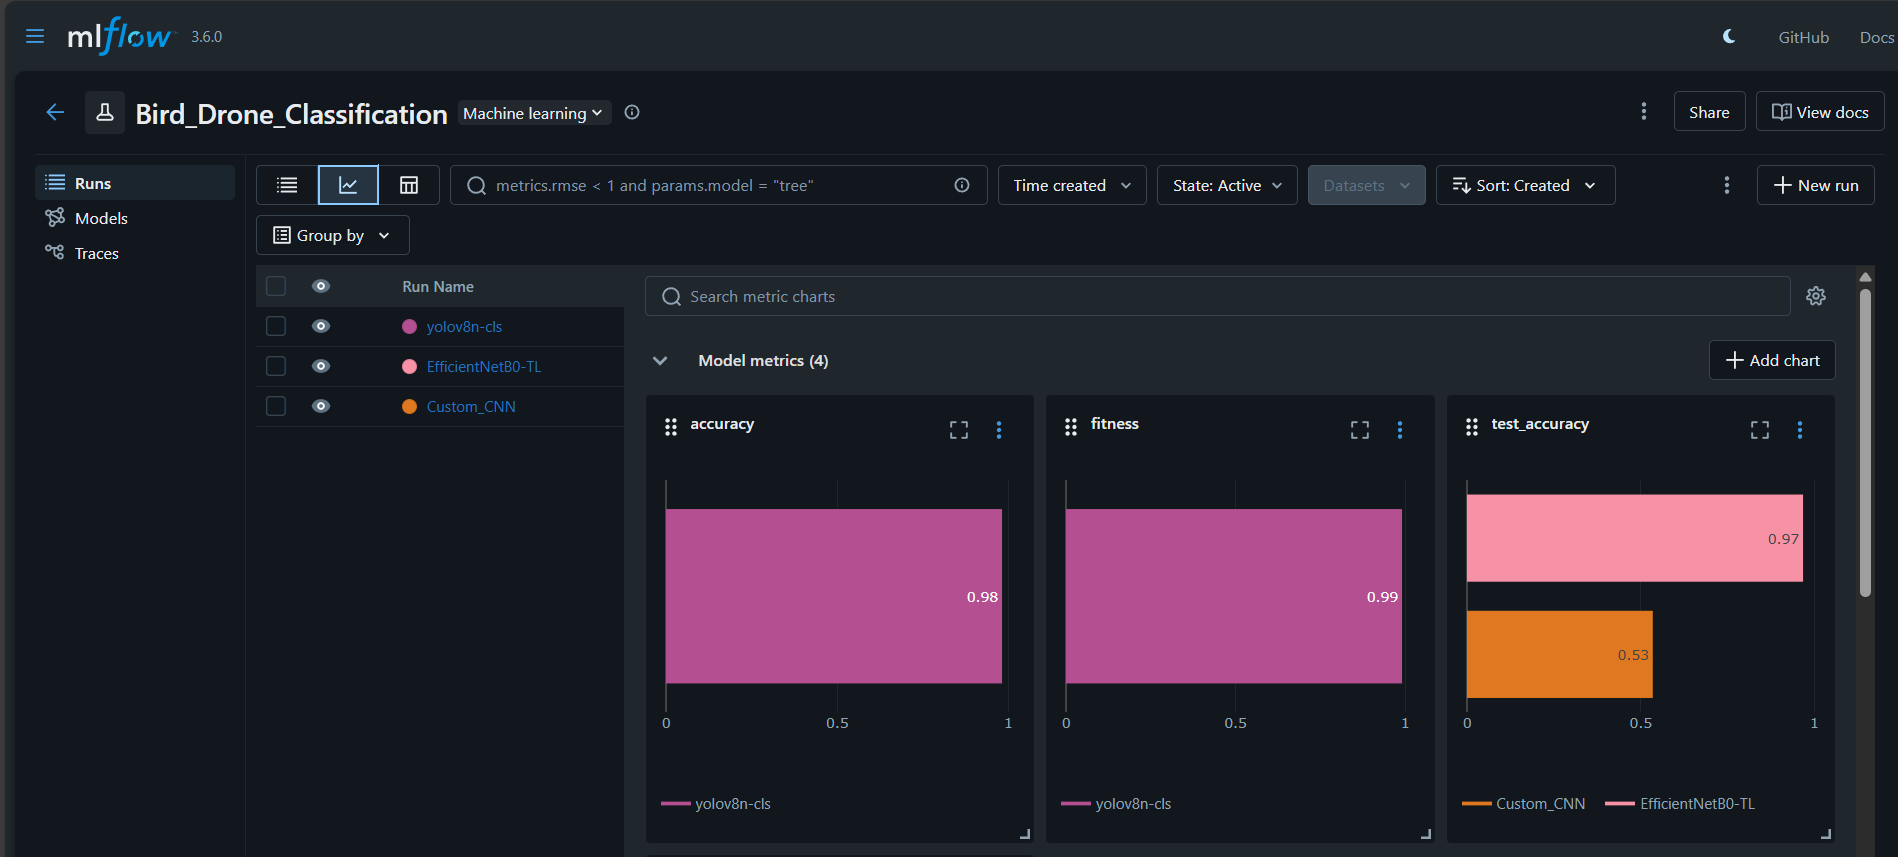

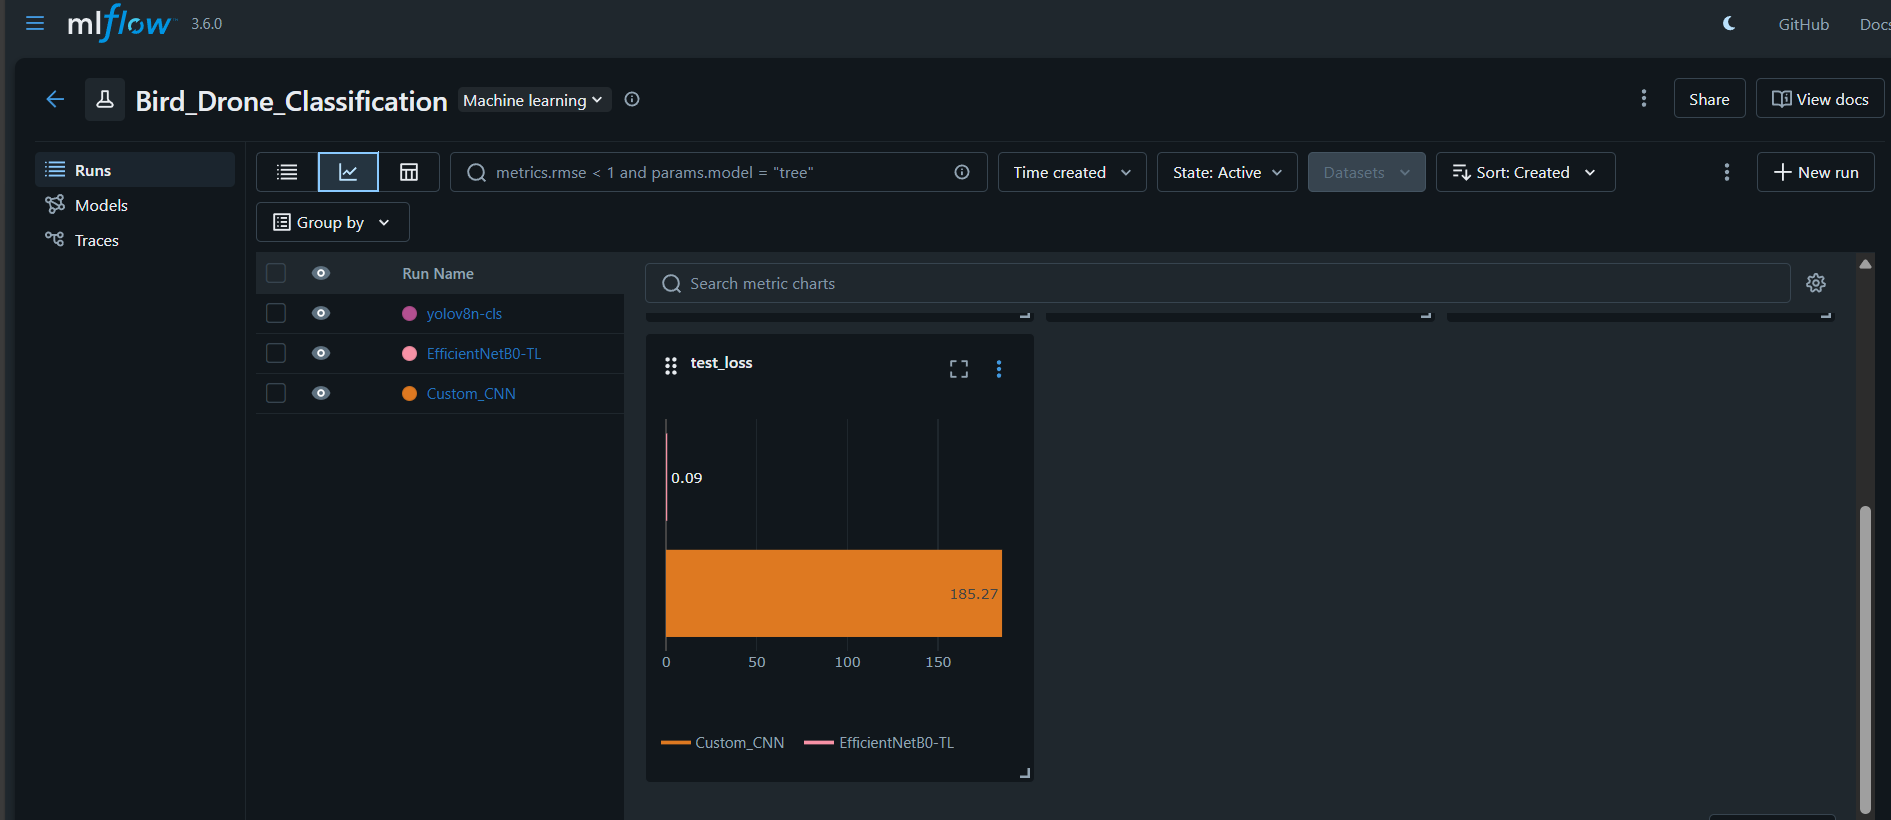

### ***Conclusion***


This project successfully implemented an end-to-end **Bird vs Drone Image Classification** system using modern deep learning techniques. Beginning with a structured dataset of aerial images, the workflow followed a complete machine learning pipeline: dataset exploration, preprocessing, augmentation, model development, evaluation, experiment tracking, and finally real-world deployment.

The first stages involved inspecting the dataset and understanding the distribution of images across the two classes. Appropriate preprocessing steps and controlled data augmentation were applied to improve model generalization while preventing overfitting. Three distinct modeling approaches were explored:

**Custom CNN Model** – Built from scratch to understand feature extraction and classification fundamentals.

**YOLOv8 Classification Model** – Leveraged the Ultralytics YOLOv8-CLS architecture for fast training and strong baseline performance.

**Transfer Learning with EfficientNetB0** – A pre-trained model fine-tuned on the bird–drone dataset to capture high-level visual semantics.

Throughout training and evaluation, metrics such as accuracy, precision, recall, and confusion matrices were used to compare model performance. All experiment results were systematically logged and tracked using MLflow, ensuring full transparency, reproducibility, and a comprehensive comparison across models.

Among all the approaches, **the Transfer Learning model (EfficientNetB0)** delivered the most reliable and consistently high performance across training, validation, and test datasets. Its superior accuracy and balanced precision–recall scores made it the preferred choice for deployment.

Finally, the selected transfer learning model was integrated into a fully functional Streamlit web application, enabling users to upload an image and receive real-time predictions with confidence scores. This deployment demonstrates the practical applicability of the model and completes the pipeline from raw data to a user-facing AI system.

Overall, this project showcases the full lifecycle of a deep learning application—from data preparation to model comparison, experiment management, and final deployment—highlighting the effectiveness of transfer learning as the optimal solution for aerial object classification.